# Classifying SNe

`Authors: Carolina Núñez, Vicente Pedreros, Antonio Vitalic`

The Dark Energy Science Collaboration released a new dataset with simulated light curves from LSST, including many classes of transient and persistent sources, including light curves and host information: [training set](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset)

In this project you are asked to build a classifier that can discriminate between the three classes of SNe: SNII (SNII-Templates, SNII-HostXT_V19 and SNII-NMF), SNIa (SNIa-91bg, SNIa-SALT2 and SNIax) and SNIbc (SNIb+HostXT_V19, SNIb-Templates, SNIc+HostXT_V19, SNIc-Templates, SNIcBL+HostXT_V19).
You can use metadata and light curve information.


Basic libraries are imported. Note that `Table` is used to transform the fits files to a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import os, fnmatch, glob

## Curating the data

The first thing to do is import the data. The function `to_df` will recieve the path to the first model of each class and return a dataframe. Note that the columns corresponding to the simulation data are dropped.

In [2]:
head_filenames = fnmatch.filter(glob.glob('data_rn/*'), '*HEAD.FITS.gz')
# classes = [x.replace('_HEAD.FITS.gz', '').replace('data_rn/', '') for x in head_filenames]


In [3]:
def to_df(filename):
    """
    This function recieves a filename and will create a dataframe by using the HEAD's and PHOT's files.
    The columns corresponding to simulation information are droppped.
    """
    cl = filename.replace('_HEAD.FITS.gz', '').replace('data_rn/', '')  # Name of the class
    
    df_train = Table.read(filename, format='fits').to_pandas()
    for col in ['SNID', 'IAUC', 'SIM_MODEL_NAME', 'SIM_TYPE_NAME']:
        df_train[col] = df_train[col].apply(lambda row: row.decode("utf-8").strip())
    
    df_lc = Table.read(filename.replace("HEAD", "PHOT"), format='fits').to_pandas()
    for col in ['BAND', 'FIELD']:
        df_lc[col] = df_lc[col].apply(lambda row: row.decode("utf-8").strip())
    
    # The data from HEAD and PHOT are grouped.
    df = df_train.groupby("SNID").apply(lambda df: df_lc.iloc[df.PTROBS_MIN.iloc[0]-1:df.PTROBS_MAX.iloc[0]-1]).reset_index()
    df = pd.merge(df_train, df, left_on='SNID', right_on='SNID')
    
    # Simulation information is dropped
    SIM_cols = [col for col in df.columns if 'SIM' in col]
    df = df.drop(SIM_cols, axis=1)

    # A column containing the name of the class is added
    s = [cl for x in range(len(df))] # Array of strings containing the name of the class
    clas = pd.DataFrame(s)
    df.insert(0, 'CLASS', s)
    return df


In [4]:
dataframes = []

for fn in head_filenames:
    dataframes.append(to_df(fn))

df_train = pd.concat(dataframes)
df_train

,CLASS,SNID,IAUC,FAKE,RA,DEC,PIXSIZE,NXPIX,NYPIX,SNTYPE,...,PSF_SIG2,PSF_RATIO,SKY_SIG,SKY_SIG_T,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,XPIX,YPIX
0,SNIa-91bg,27528421,NULL,2,64.849535,-14.710349,0.2,-9,-9,111,...,0.0,0.0,48.169998,0.0,0.25,30.070000,0.005,1.0,-9.0,-9.0
1,SNIa-91bg,27528421,NULL,2,64.849535,-14.710349,0.2,-9,-9,111,...,0.0,0.0,46.599998,0.0,0.25,30.059999,0.005,1.0,-9.0,-9.0
2,SNIa-91bg,27528421,NULL,2,64.849535,-14.710349,0.2,-9,-9,111,...,0.0,0.0,61.029999,0.0,0.25,30.990000,0.005,1.0,-9.0,-9.0
3,SNIa-91bg,27528421,NULL,2,64.849535,-14.710349,0.2,-9,-9,111,...,0.0,0.0,23.629999,0.0,0.25,31.510000,0.005,1.0,-9.0,-9.0
4,SNIa-91bg,27528421,NULL,2,64.849535,-14.710349,0.2,-9,-9,111,...,0.0,0.0,43.040001,0.0,0.35,32.049999,0.005,1.0,-9.0,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282956,SNIb+HostXT_V19,74595032,NULL,2,139.037782,-4.411979,0.2,-9,-9,121,...,0.0,0.0,70.919998,0.0,0.35,31.719999,0.005,1.0,-9.0,-9.0
282957,SNIb+HostXT_V19,74595032,NULL,2,139.037782,-4.411979,0.2,-9,-9,121,...,0.0,0.0,61.799999,0.0,0.35,30.809999,0.005,1.0,-9.0,-9.0
282958,SNIb+HostXT_V19,74595032,NULL,2,139.037782,-4.411979,0.2,-9,-9,121,...,0.0,0.0,25.959999,0.0,0.25,31.520000,0.005,1.0,-9.0,-9.0
282959,SNIb+HostXT_V19,74595032,NULL,2,139.037782,-4.411979,0.2,-9,-9,121,...,0.0,0.0,16.260000,0.0,0.25,31.490000,0.005,1.0,-9.0,-9.0


### Visualization of data

A count plot and lighcurves (10 per class) are presented.

Text(0.5, 1.0, 'Count plot of each class')

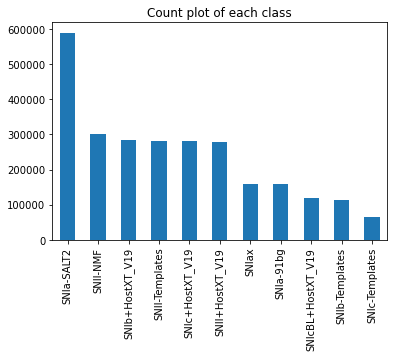

In [6]:
ax = df_train["CLASS"].value_counts().plot.bar()
ax.set_title('Count plot of each class')

In [66]:
colors = {'u': 'b', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'brown', 'Y': 'k'}

bands = ['HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r',
         'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y',]

bands2 = ['HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g', 'HOSTGAl2_MAG_r',
         'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y',]


errors= ['HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
         'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y']

errors2= ['HOSTGA2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r',
         'HOSTGA2_MAGERR_i', 'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y']

In [55]:
def plot_lc(SNID, df, path=None):
    fig, ax = plt.subplots(figsize=(14,4))
    for idx, c in enumerate(colors.keys()):
        mask = (df.SNID == str(SNID)) & (df.BAND == c)
        if mask.sum() > 0:
            ax.errorbar(df.loc[mask].MJD, df.loc[mask][bands[idx]],
                        df.loc[mask][errors[idx]], color=list(colors.values())[idx], fmt='o', ms=3, lw=0, elinewidth=1, label=c)
    ax.set_xlabel('mjd')
    ax.set_ylabel('Magnitude')
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None: fig.savefig(path+'lc_'+SNID+'.png')

In [67]:
def plot_lc_2(SNID, df, path=None):
    fig, ax = plt.subplots(figsize=(14,4))
    for idx, c in enumerate(colors.keys()):
        mask = (df.SNID == str(SNID)) & (df.BAND == c)
        if mask.sum() > 0:
            ax.errorbar(df.loc[mask].MJD, df.loc[mask][bands2[idx]],
                        df.loc[mask][errors2[idx]], color=list(colors.values())[idx], fmt='o', ms=3, lw=0, elinewidth=1, label=c)
    ax.set_xlabel('mjd')
    ax.set_ylabel('Magnitude')
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None: fig.savefig(path+'lc_'+SNID+'.png')

In [70]:
# Obtaining the samples

np.random.seed(73)

snids = []  # In this array, the snid's of the objects will be stored.

for i in range(len(df_train.CLASS.unique())):
    snids.append(
        list(df_train.loc[df_train['CLASS'].isin([df_train.CLASS.unique()[i]])].sample(10).SNID))

snids = sum(snids, [])  # Transform list of lists into a list containing each snid

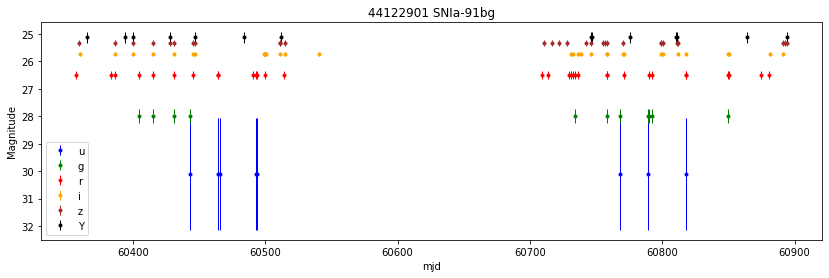

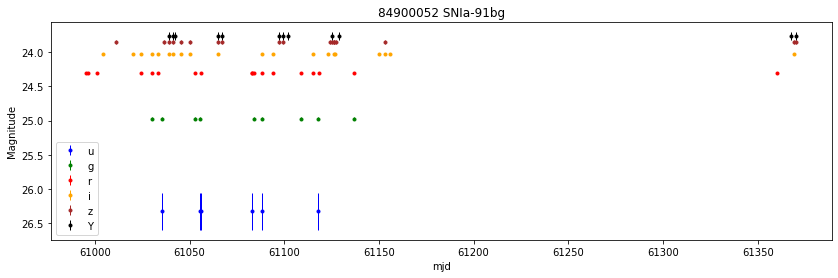

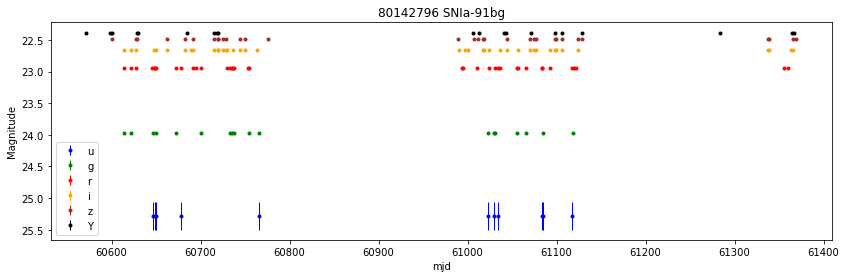

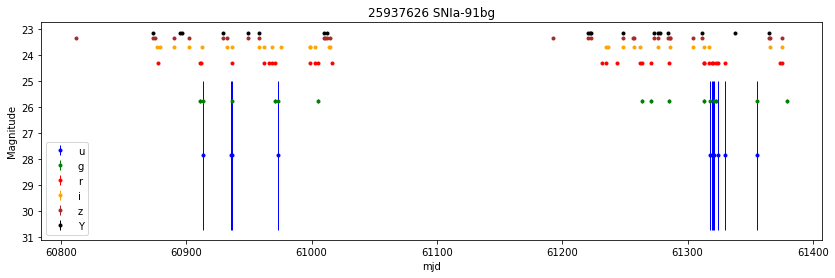

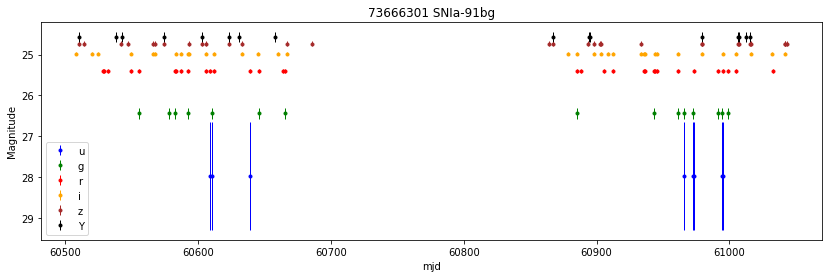

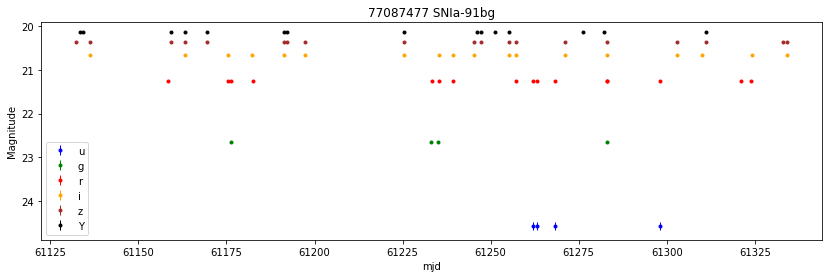

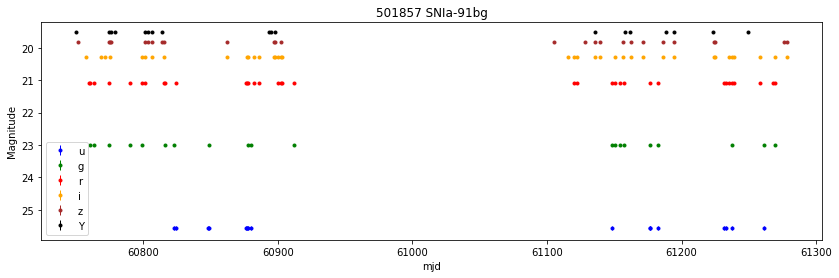

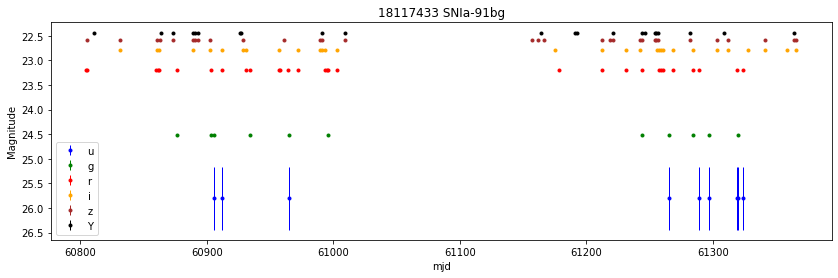

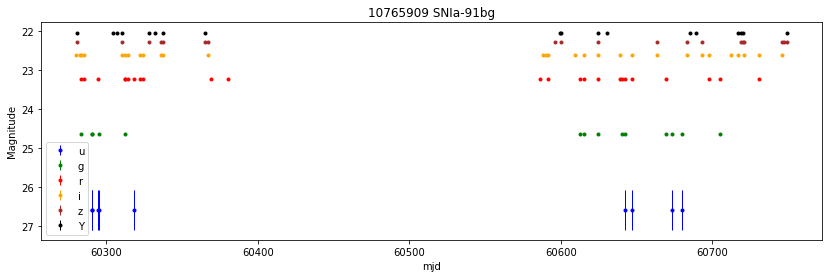

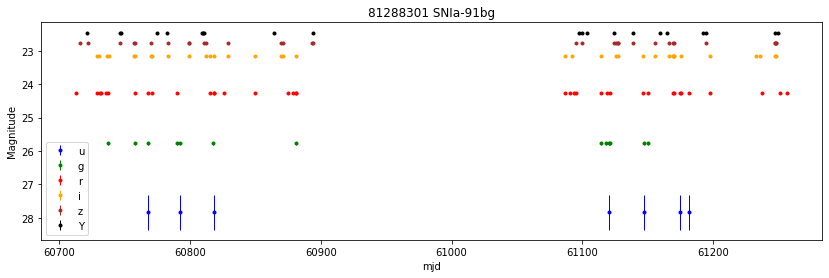

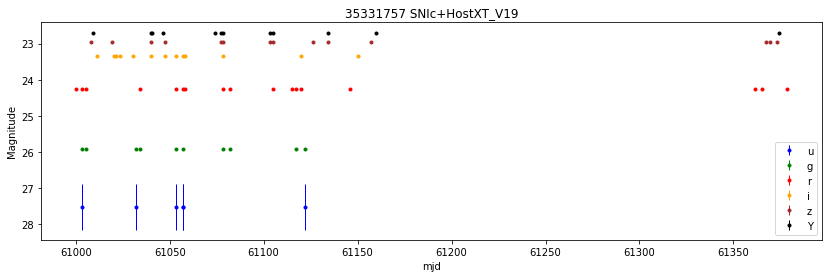

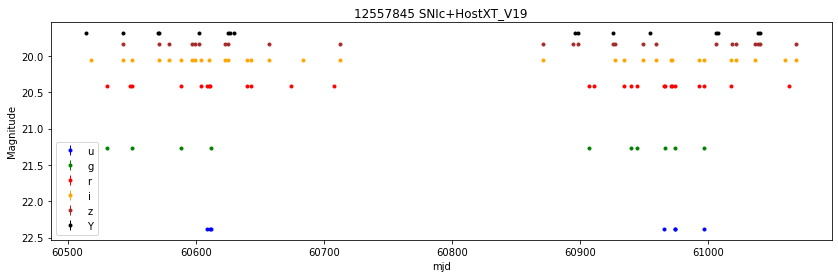

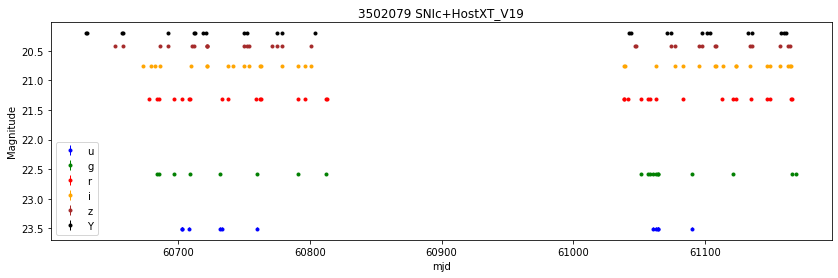

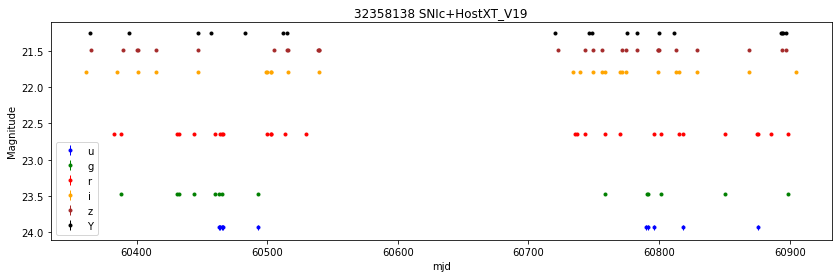

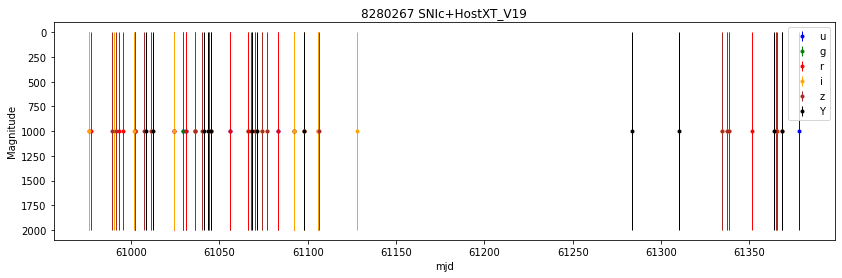

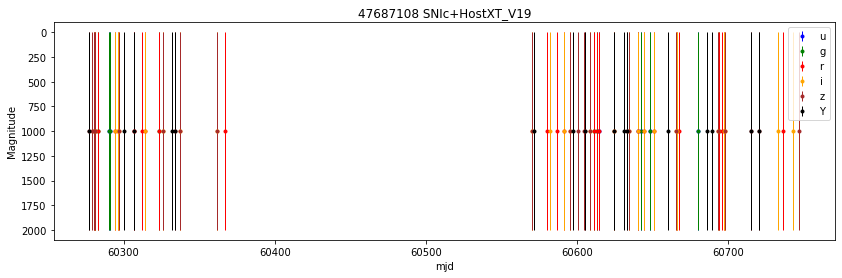

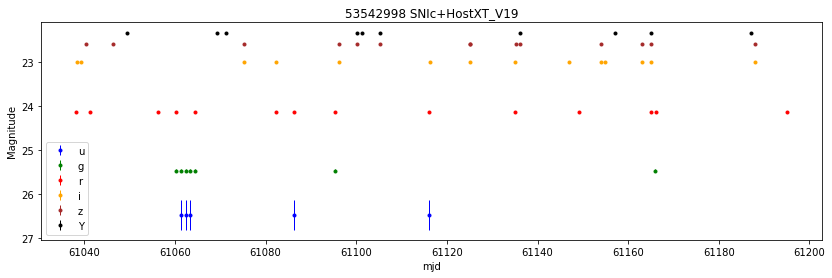

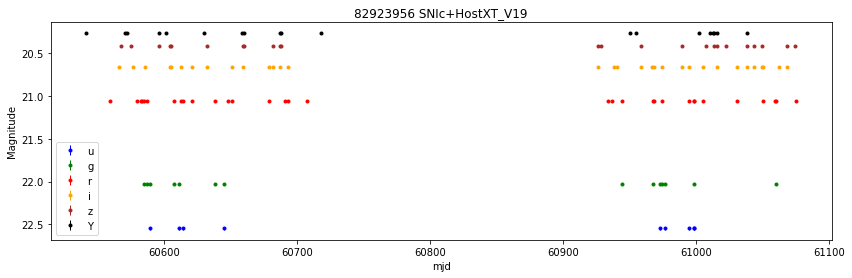

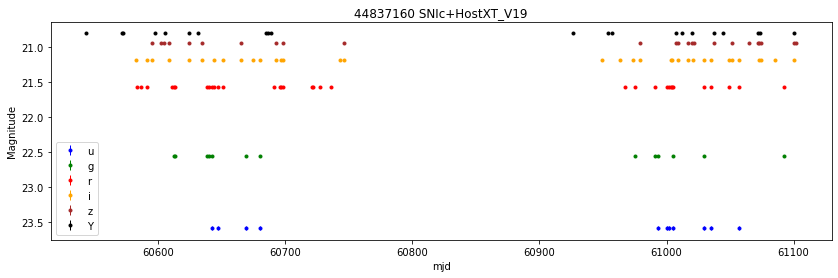

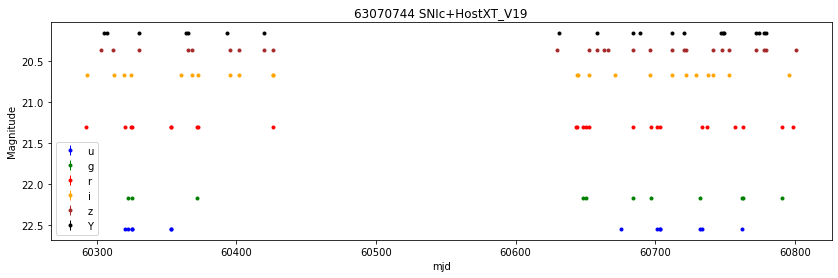

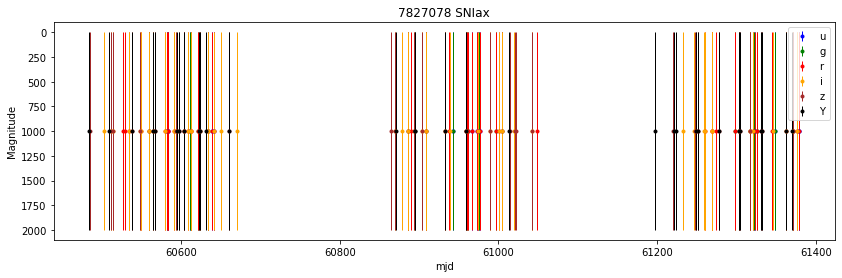

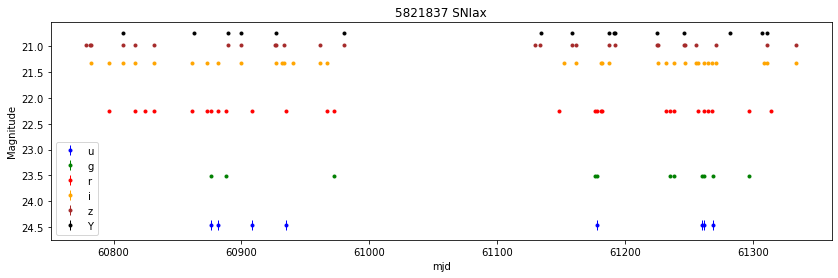

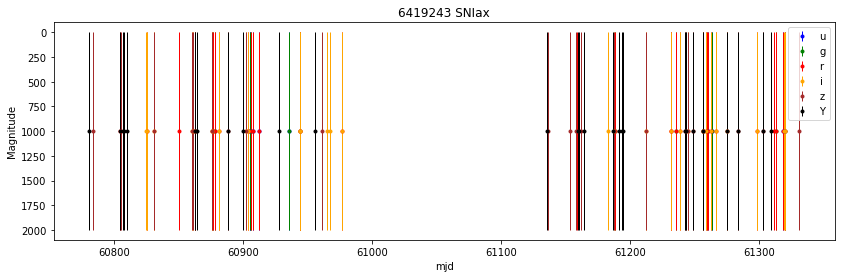

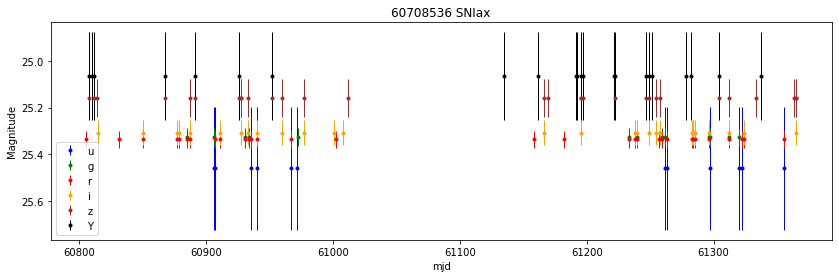

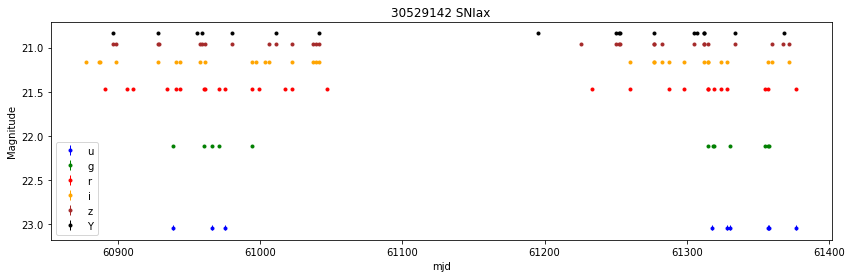

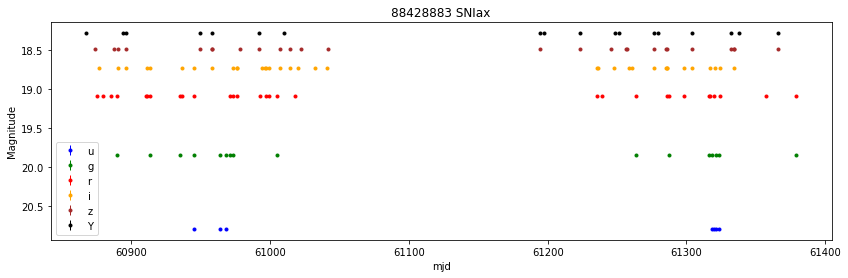

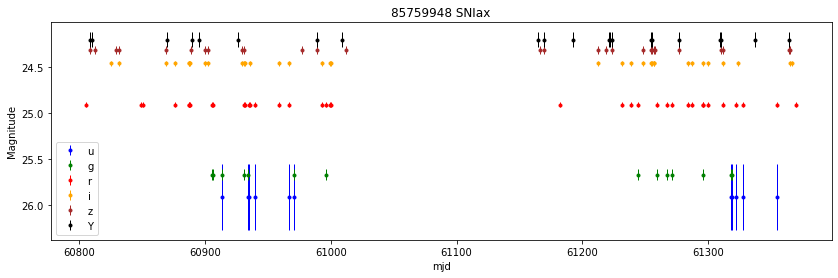

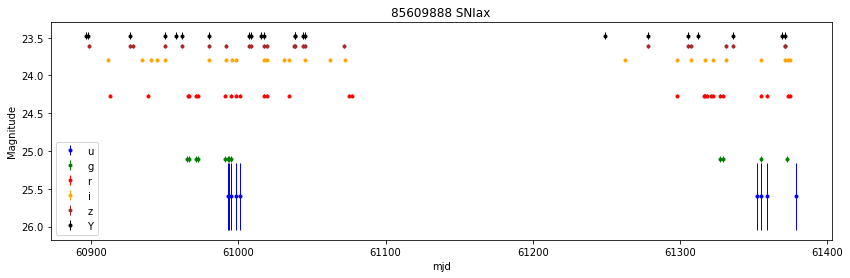

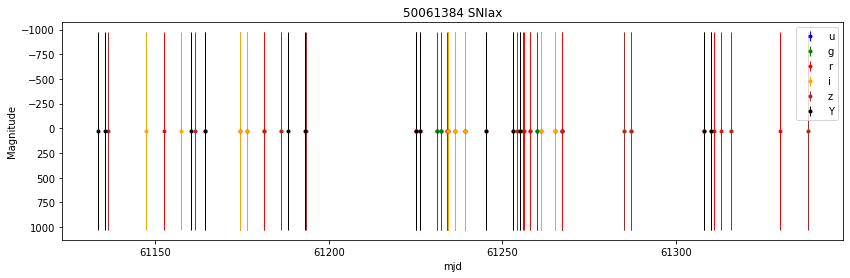

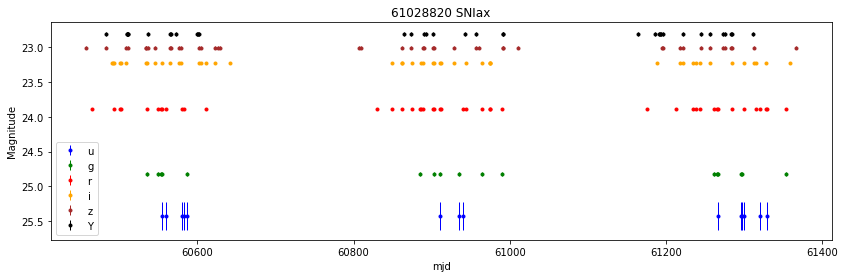

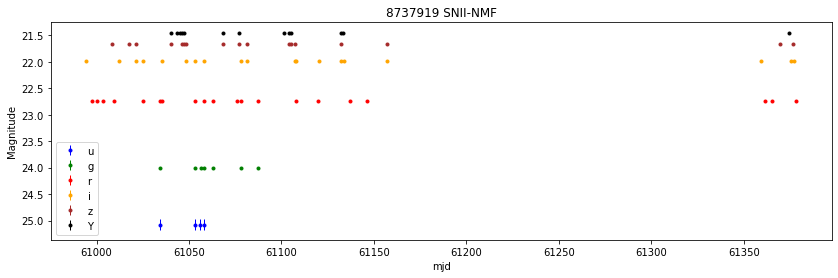

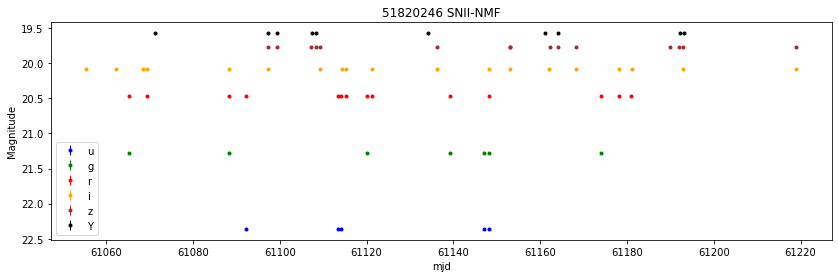

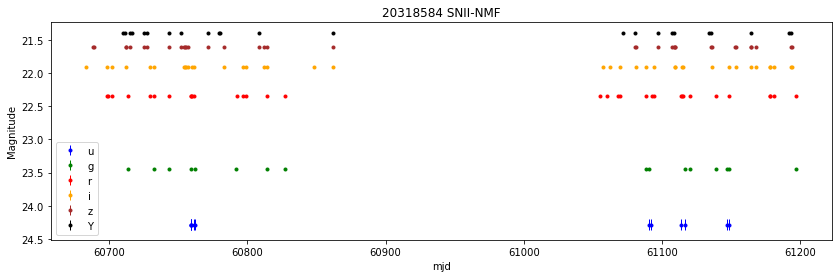

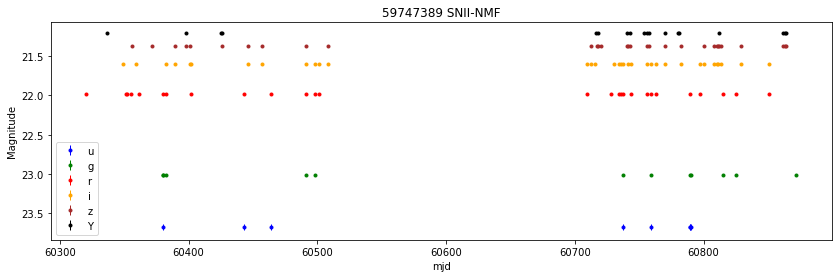

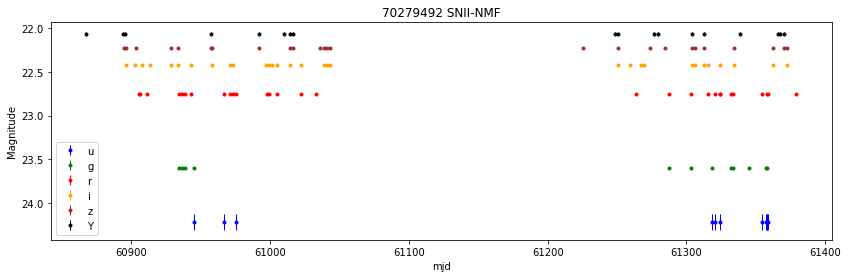

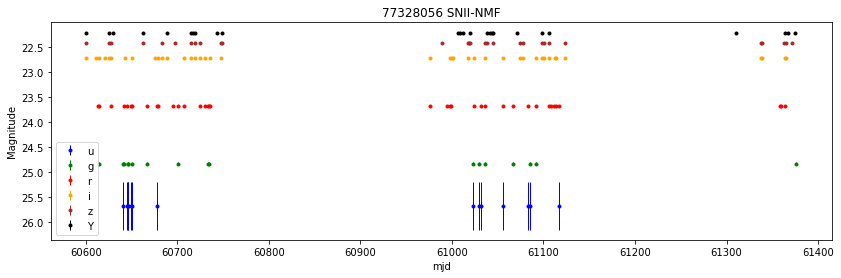

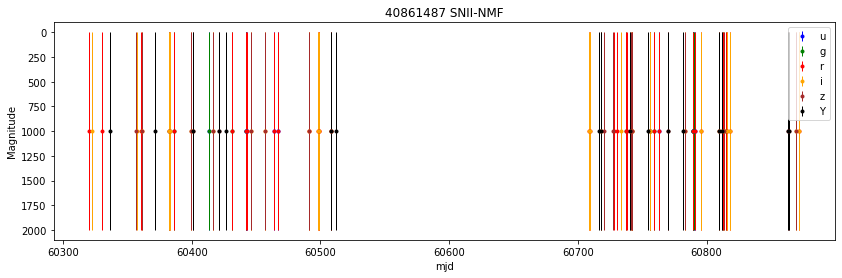

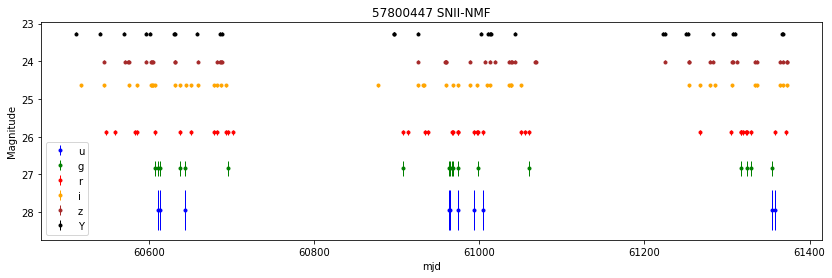

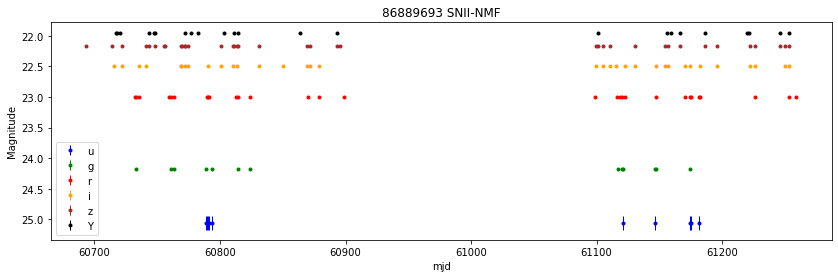

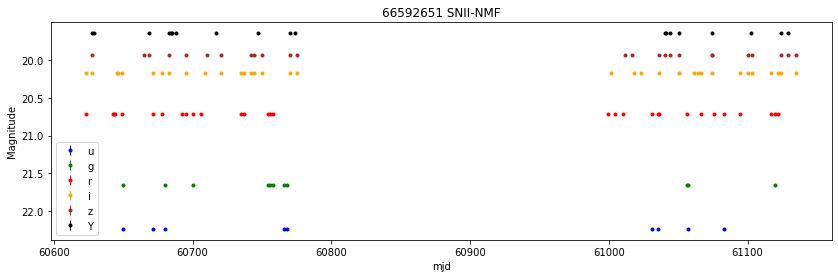

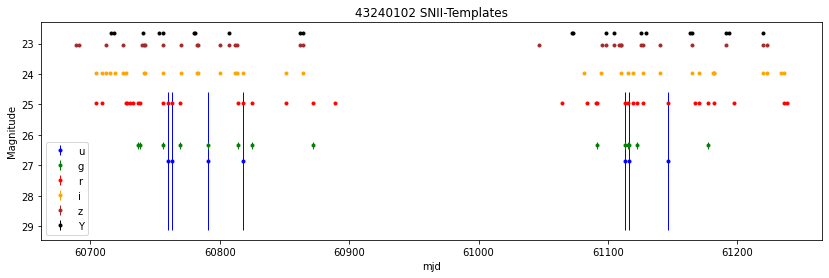

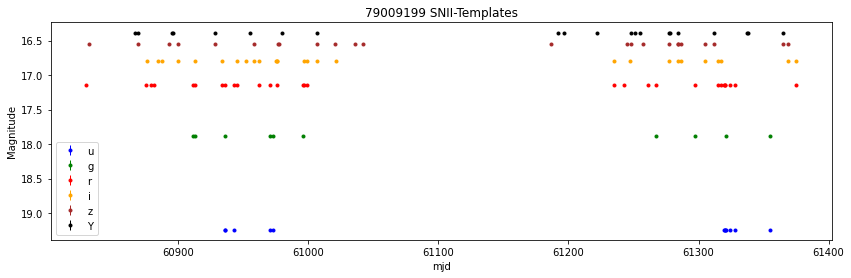

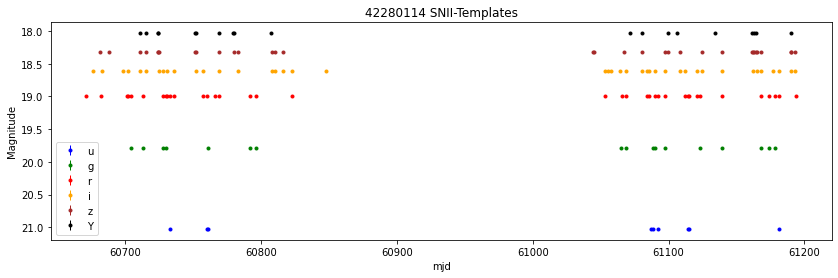

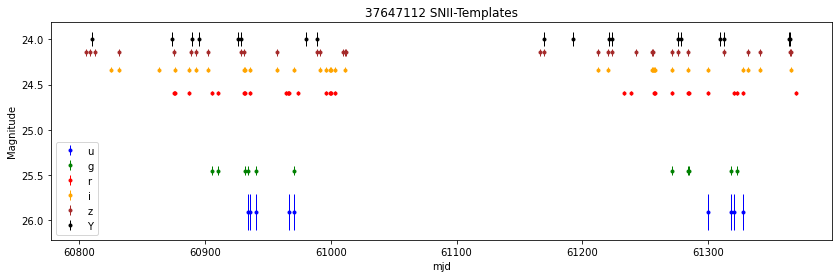

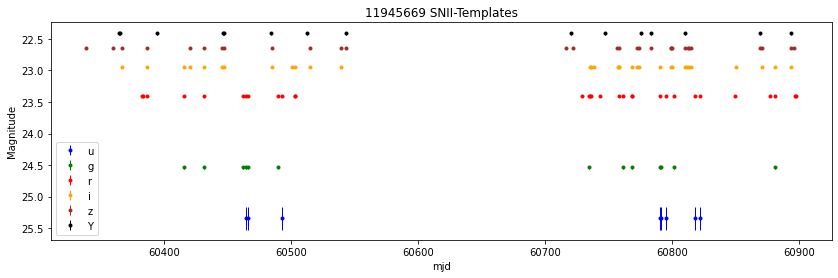

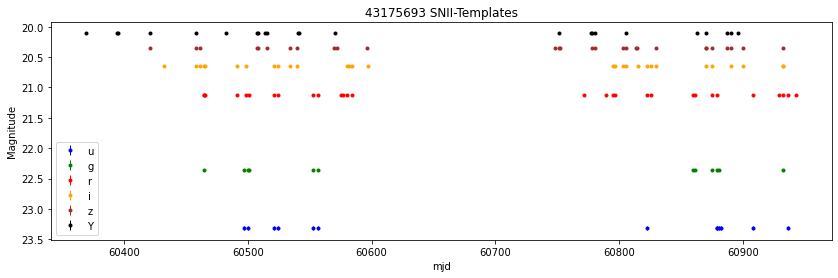

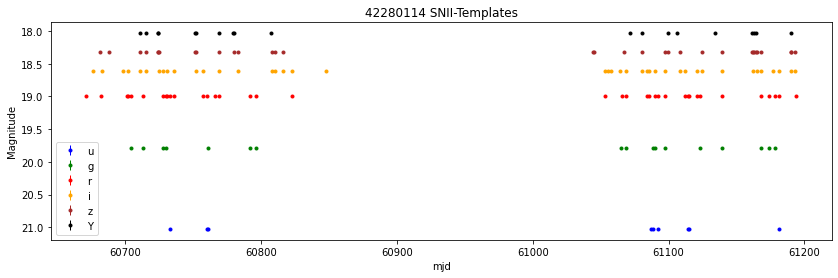

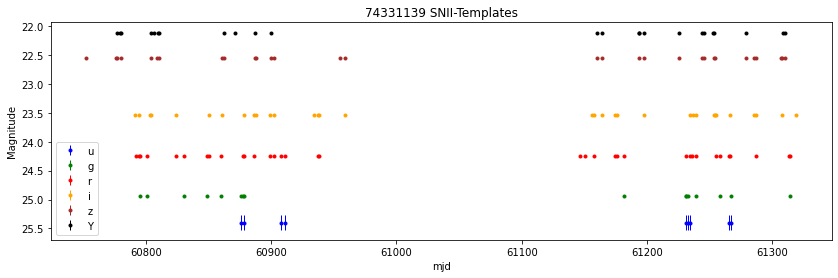

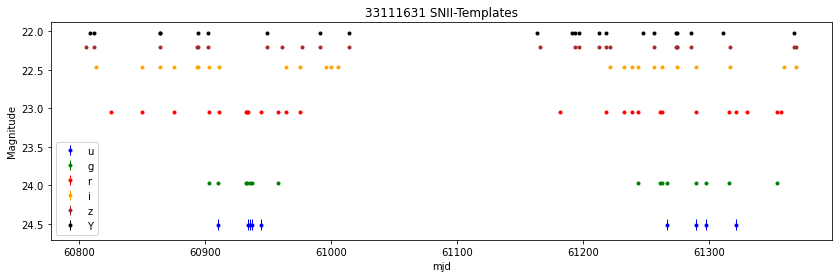

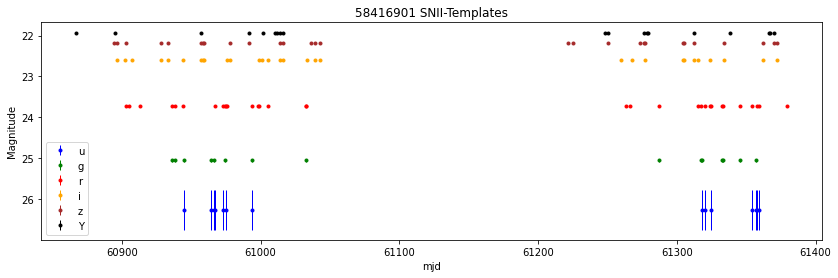

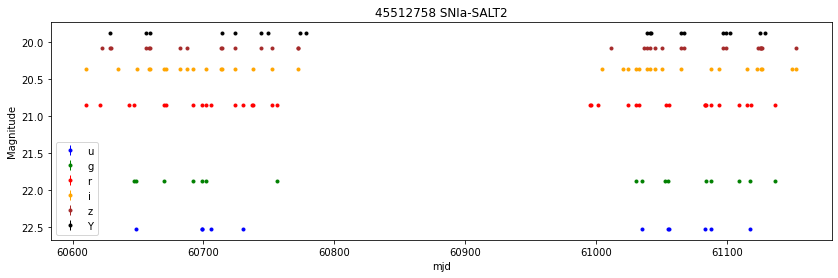

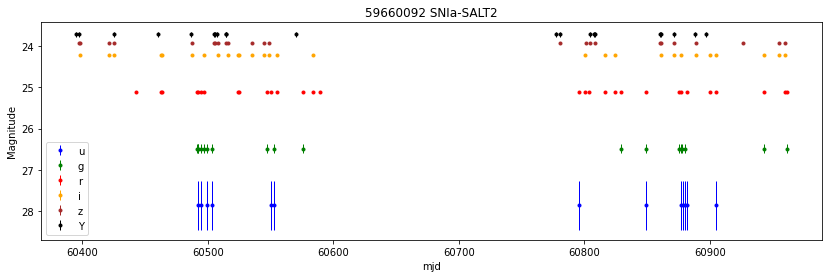

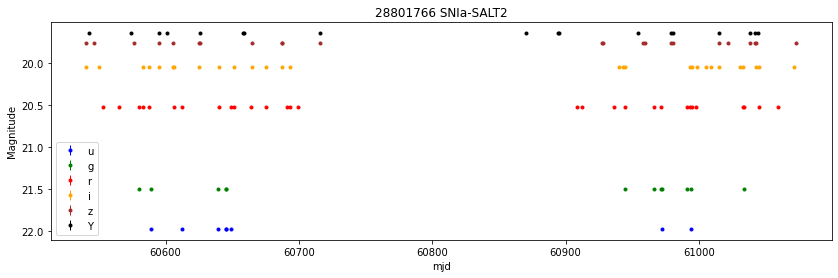

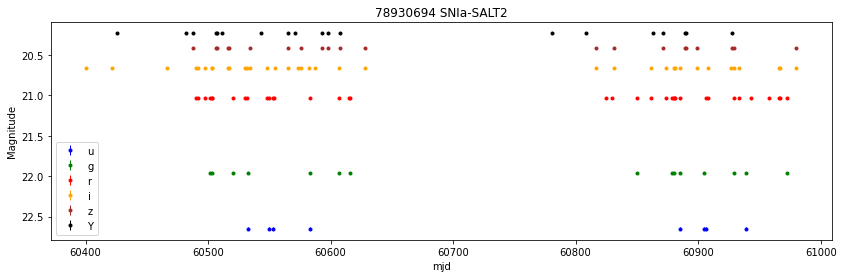

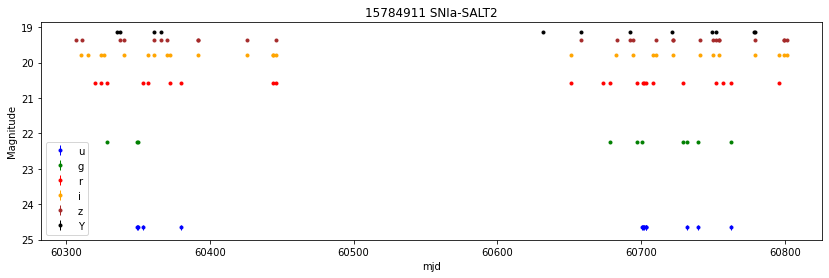

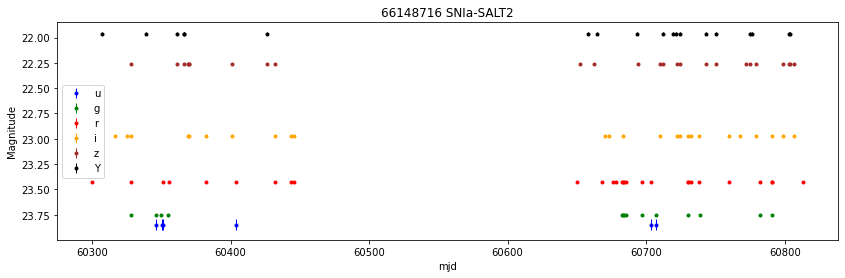

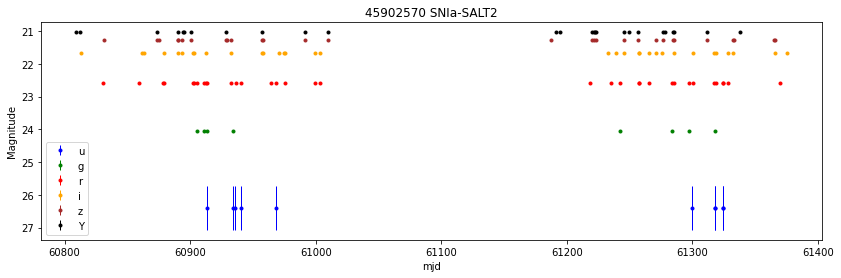

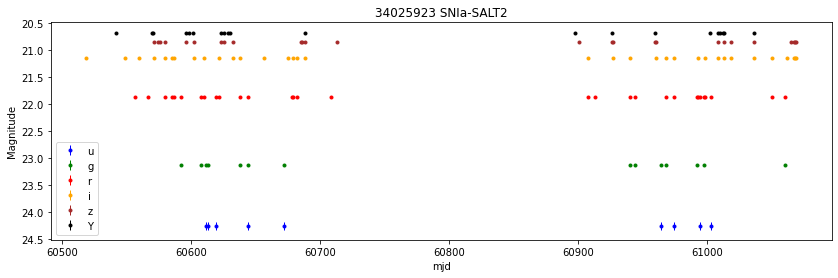

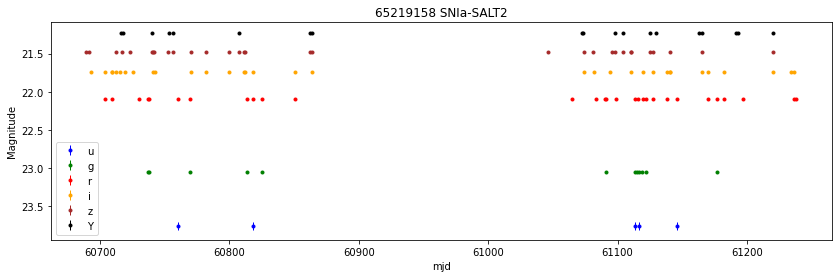

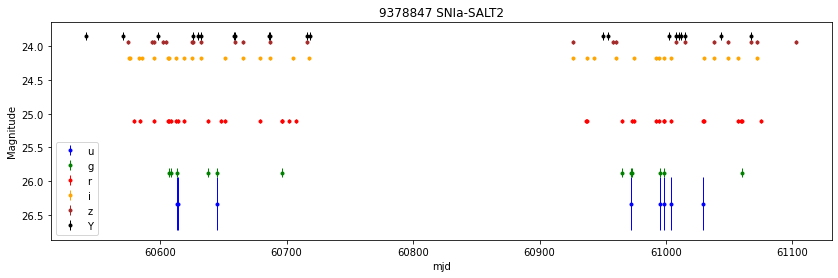

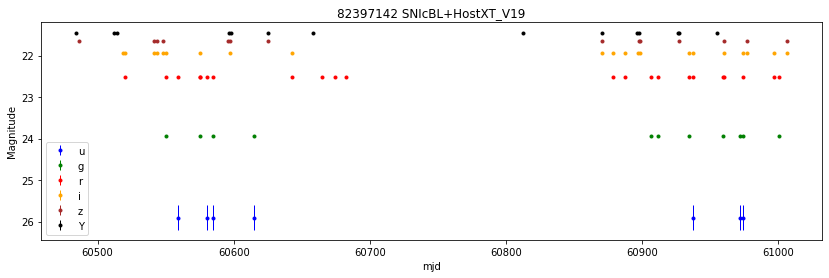

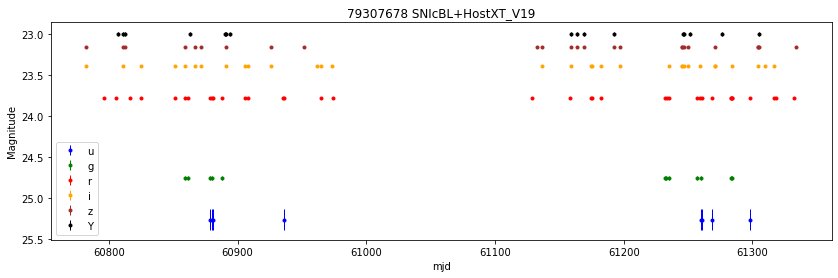

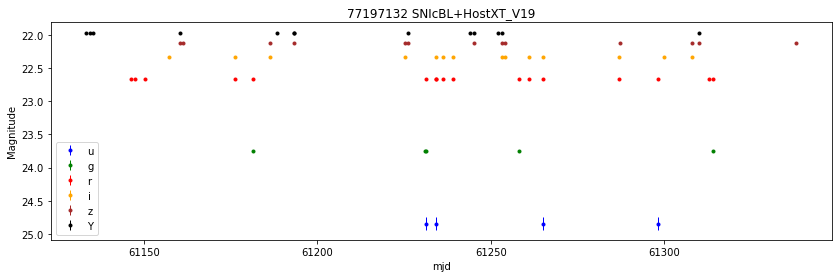

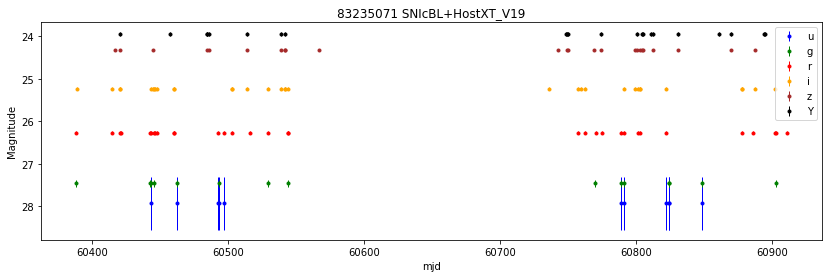

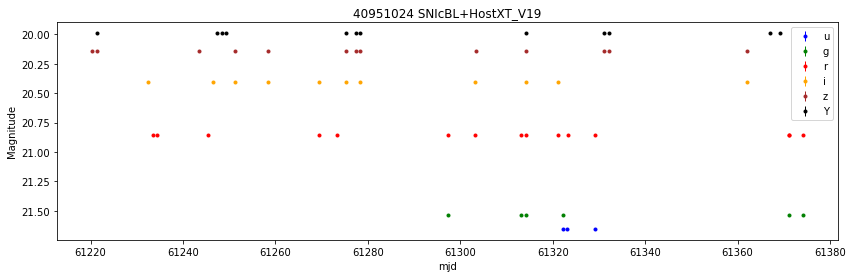

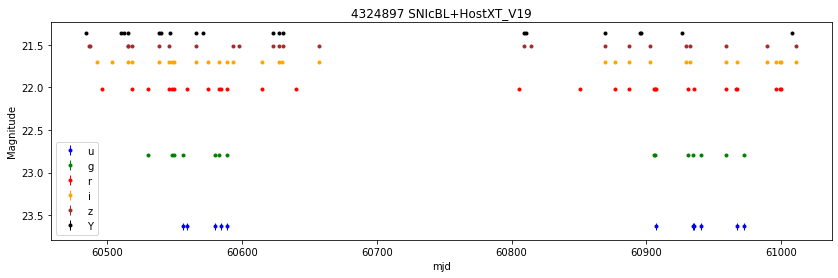

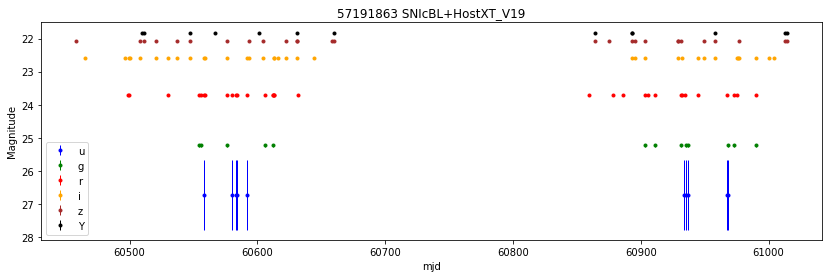

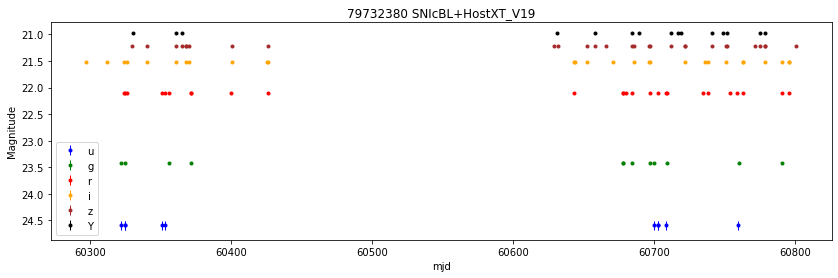

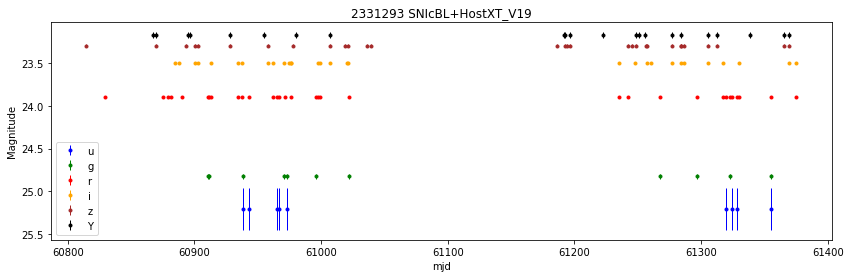

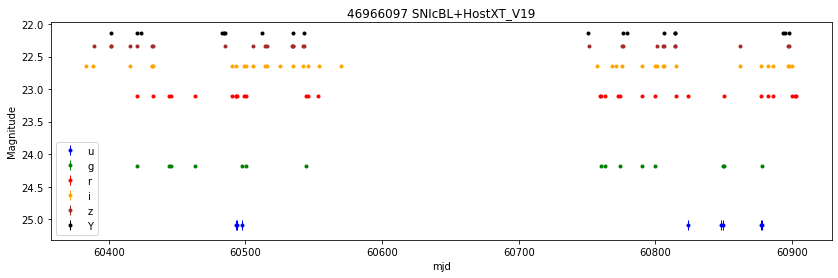

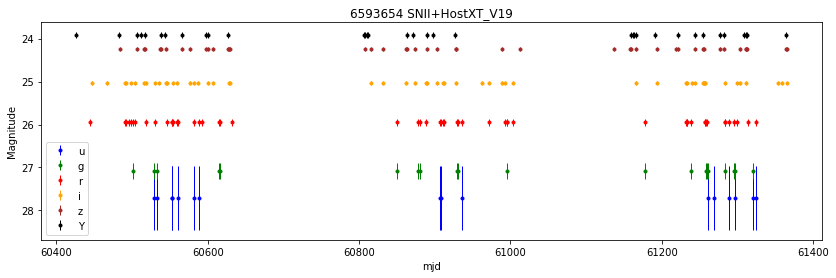

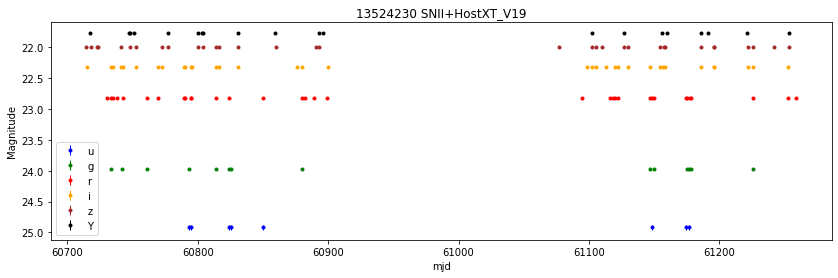

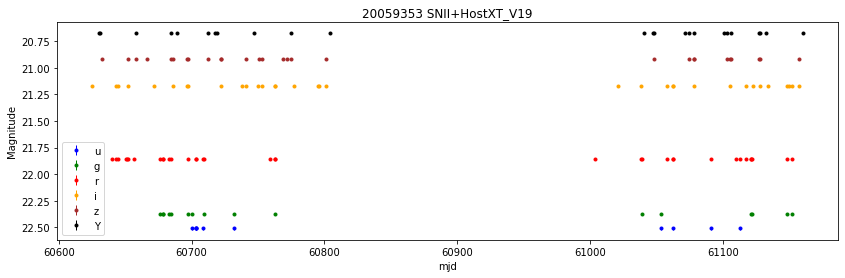

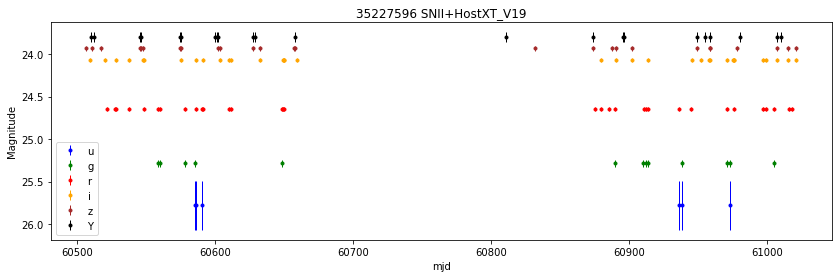

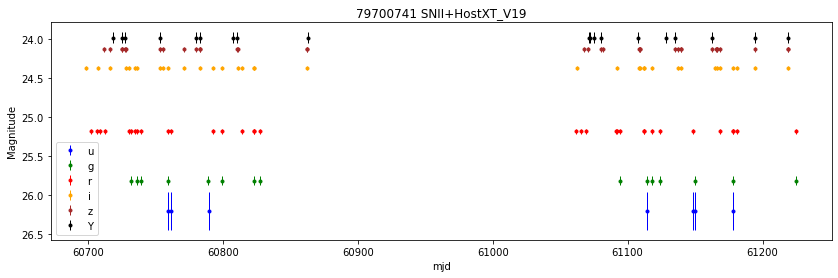

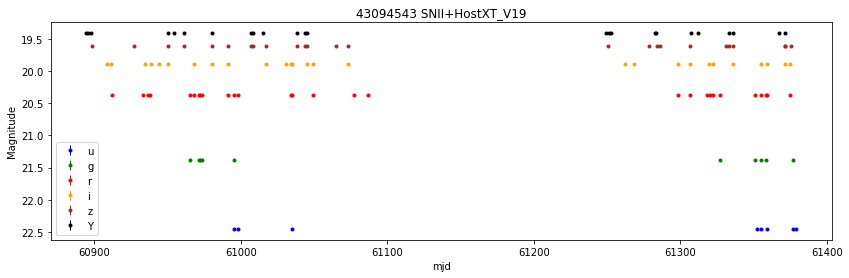

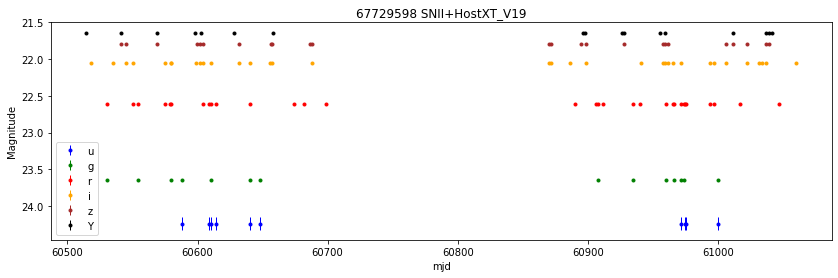

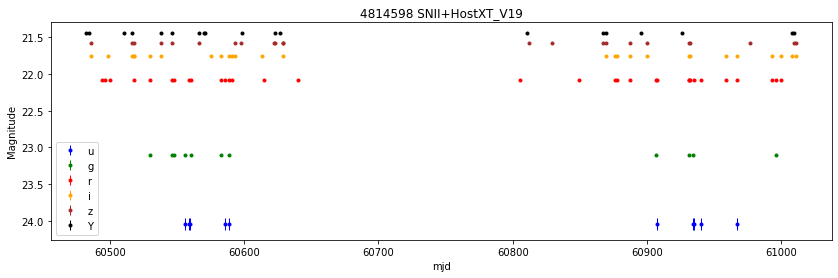

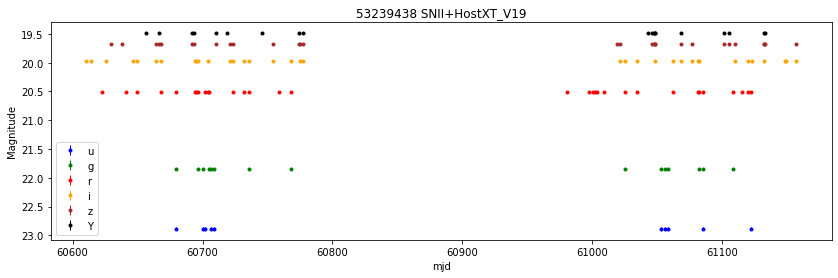

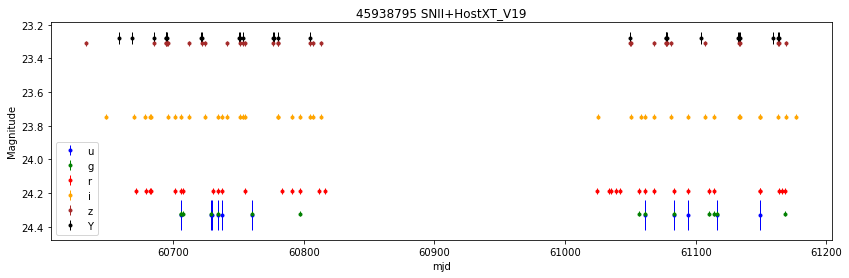

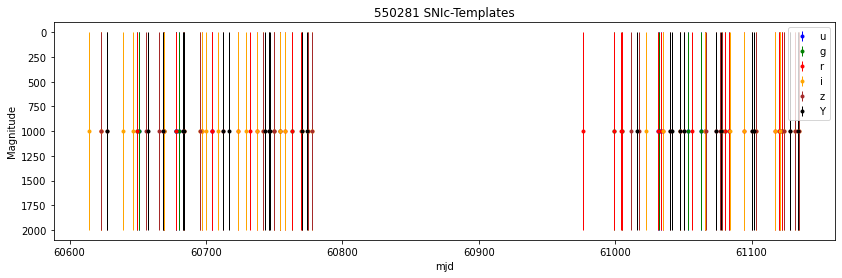

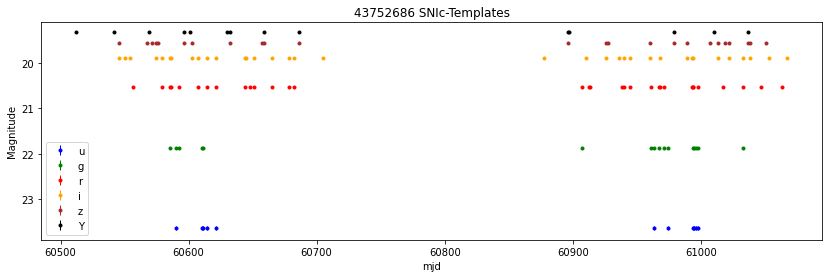

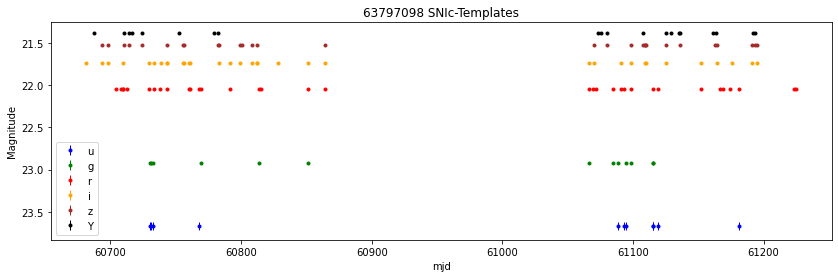

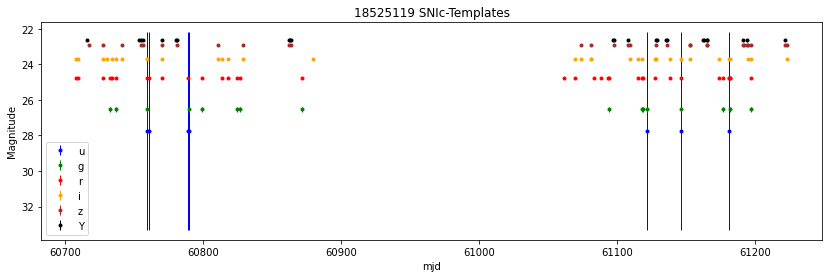

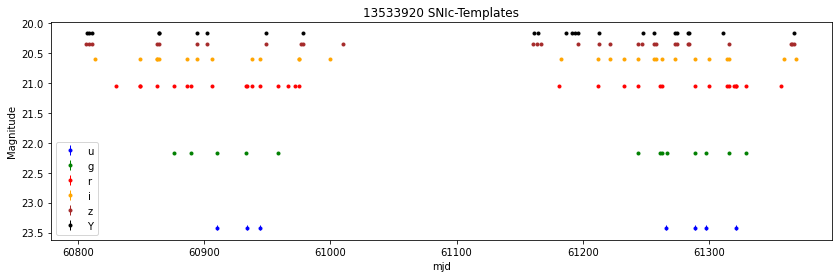

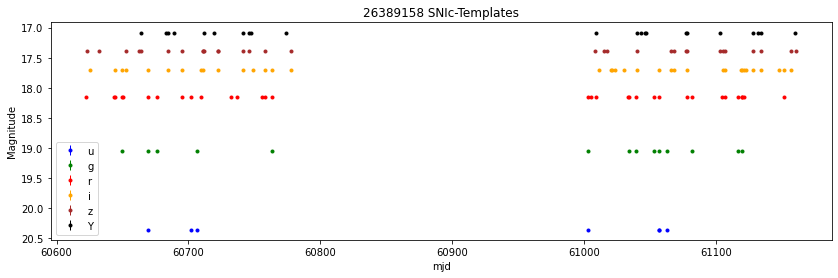

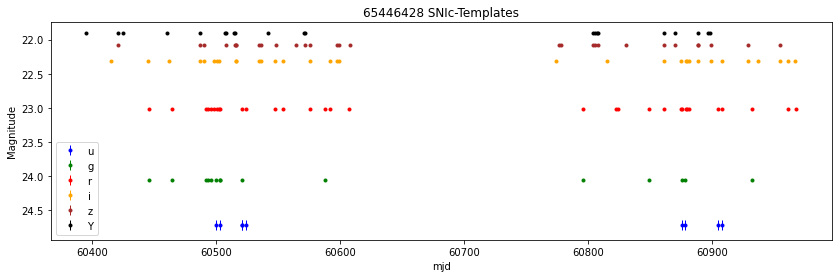

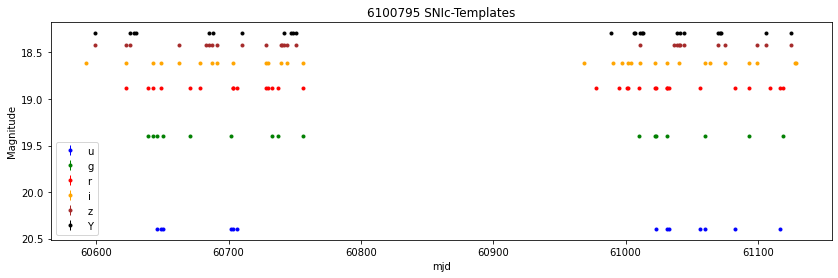

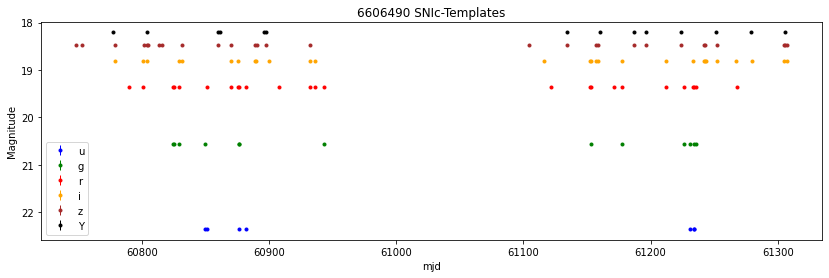

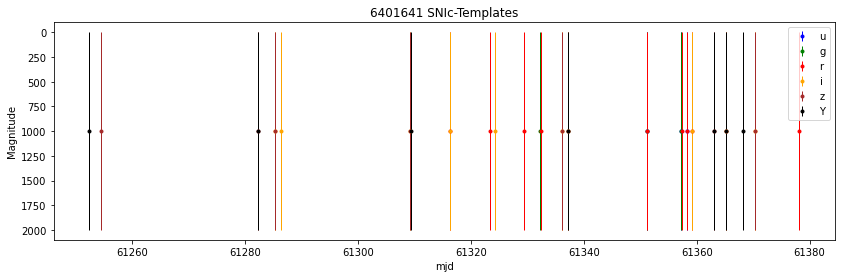

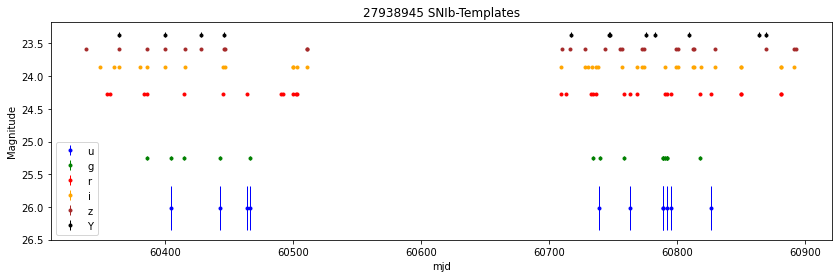

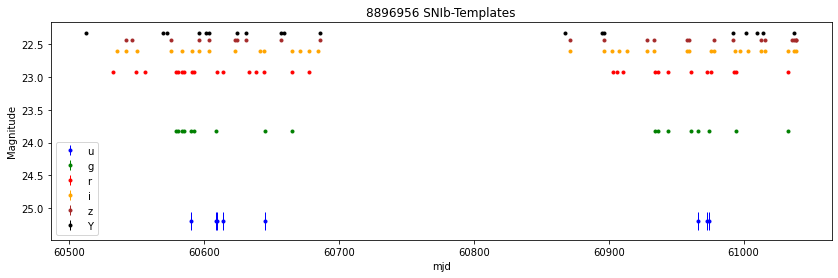

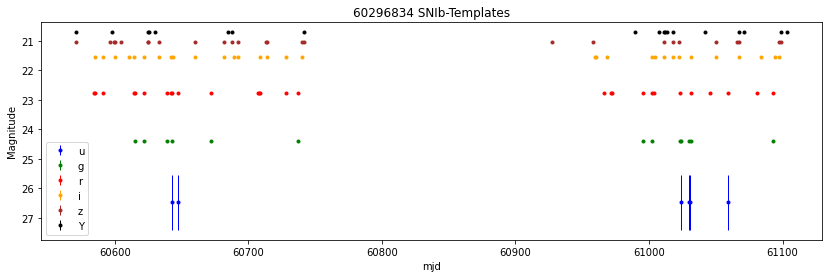

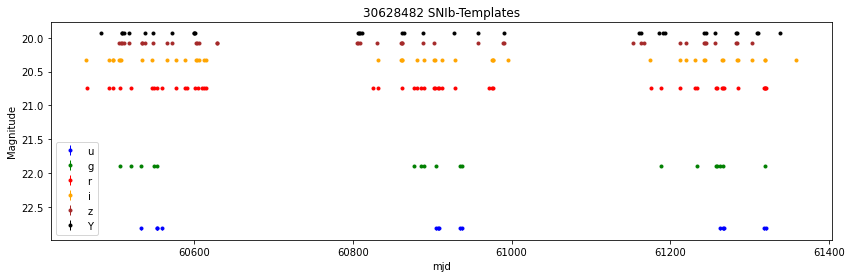

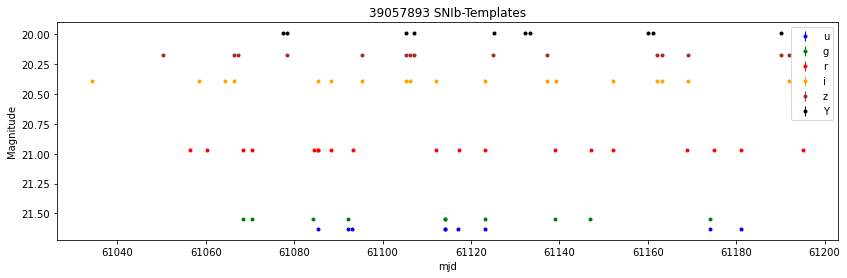

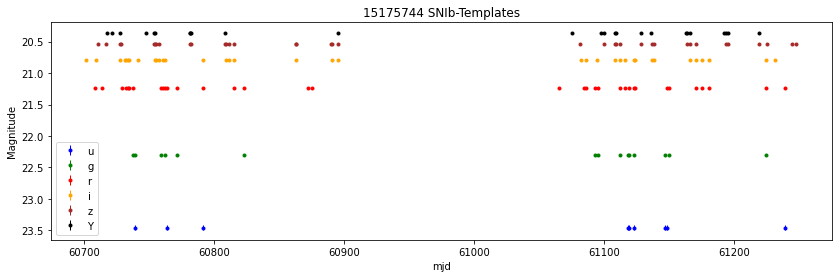

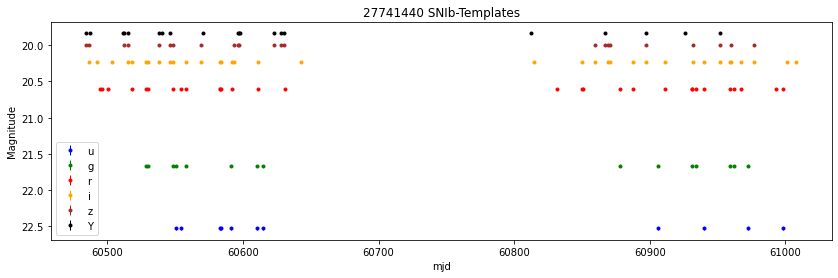

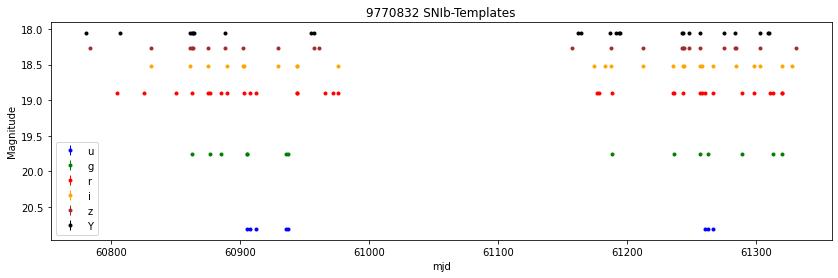

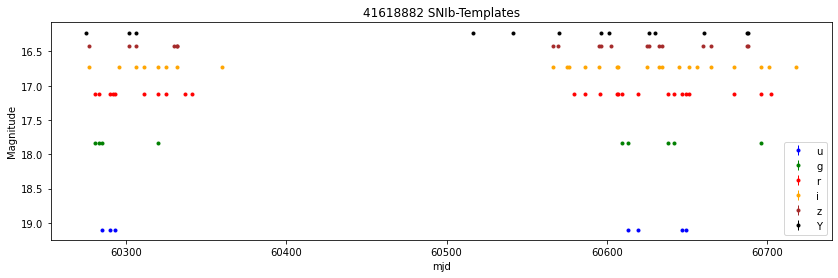

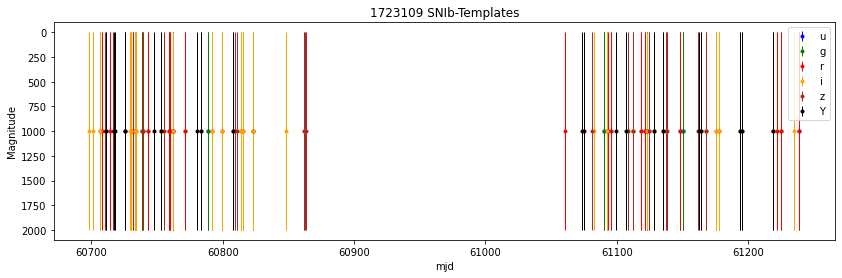

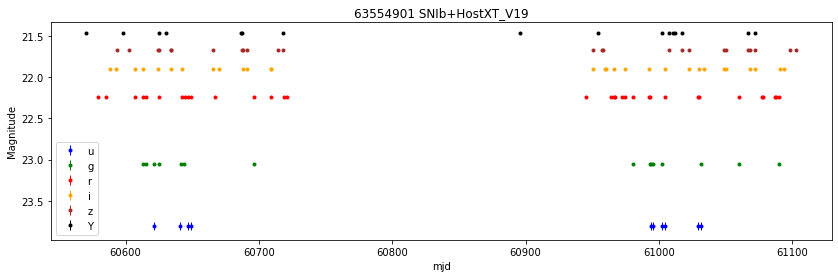

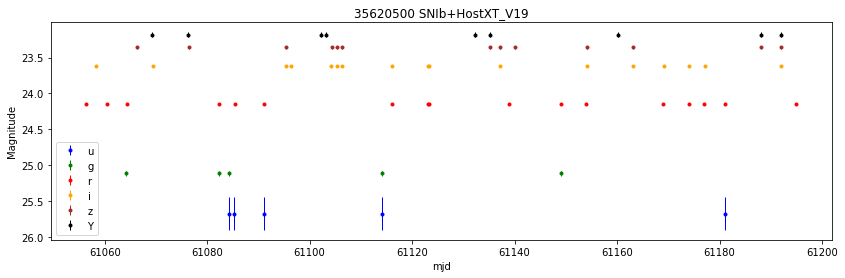

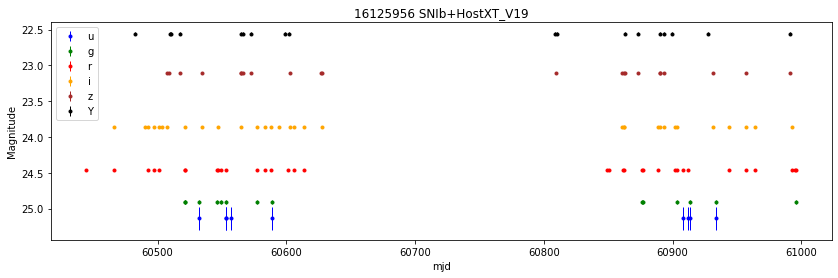

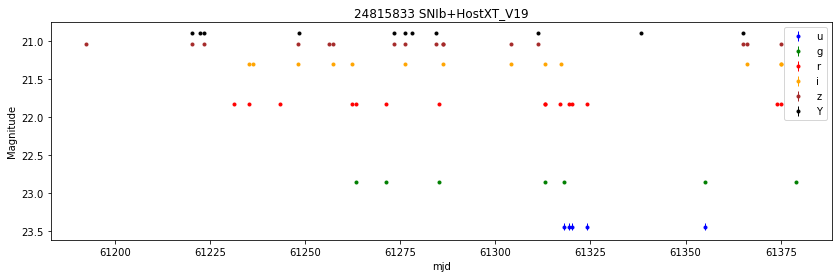

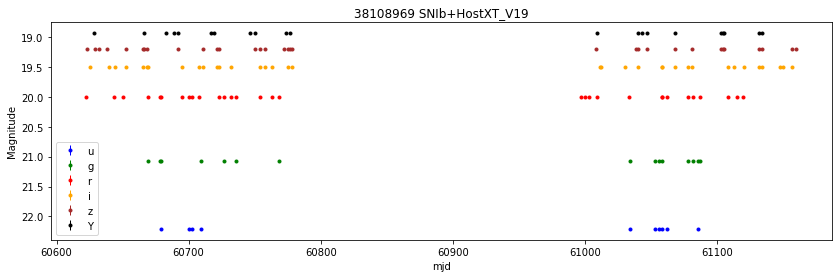

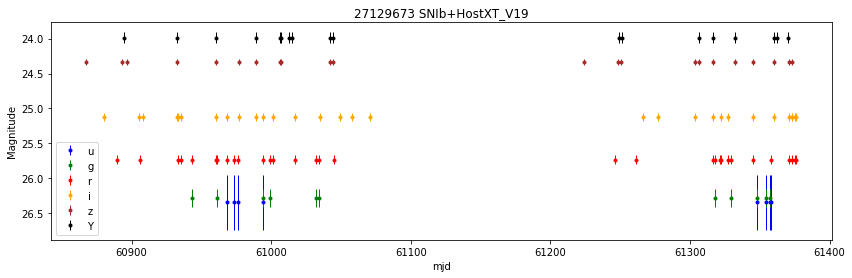

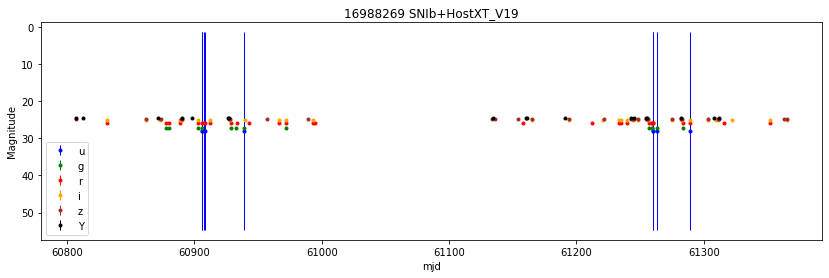

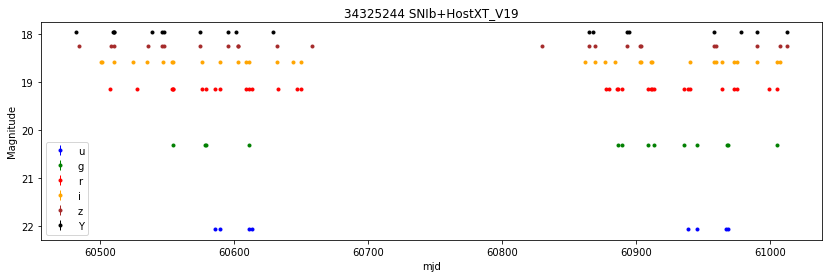

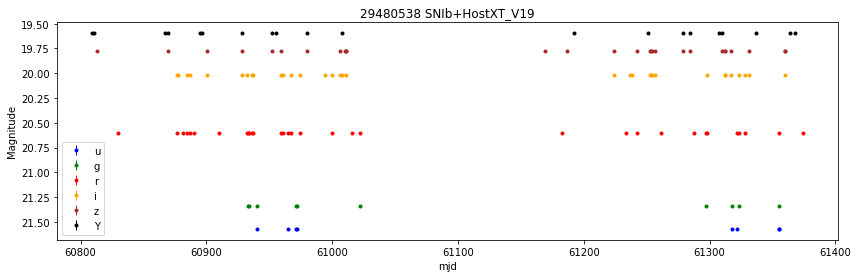

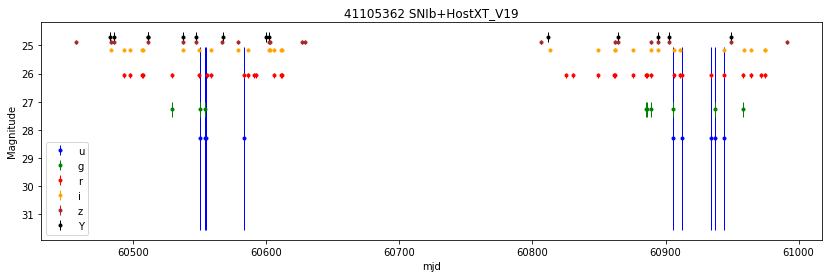

In [68]:
for snid in snids:
    plot_lc(str(snid), df_train)
    plt.show()

In [61]:
df_train.loc[df_train.SNID == '1723109'].HOSTGAL_MAG_i.unique()

array([999.], dtype=float32)